### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas
import PIL.Image as Image
# disable PIL.DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm

from utils import *

%load_ext memory_profiler

/home/pvk/Documents/python/ML/scrolls/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Set up data

In [28]:
BASE_PREFIX = 'data/' # change to your data folder
TRAIN_PREFIX = BASE_PREFIX + 'train/'
TEST_PREFIX = BASE_PREFIX + 'test/'
MODEL_SAVE_PATH = 'trained_models/model2.pt'
VALIDATION_RECTS = [(1100, 3500, 700, 950),  # validation patch to remove from each training fragment
                    (2200, 10800, 700, 950),
                    (2100, 4400, 700, 950)]
BUFFER = 30  # Buffer size in x and y direction
Z_START = 16 # First slice in the z direction to use
Z_DIM = 32   # Number of slices in the z direction
TRAINING_EPOCHS = 30000
VALIDATION_EPOCHS= 1000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


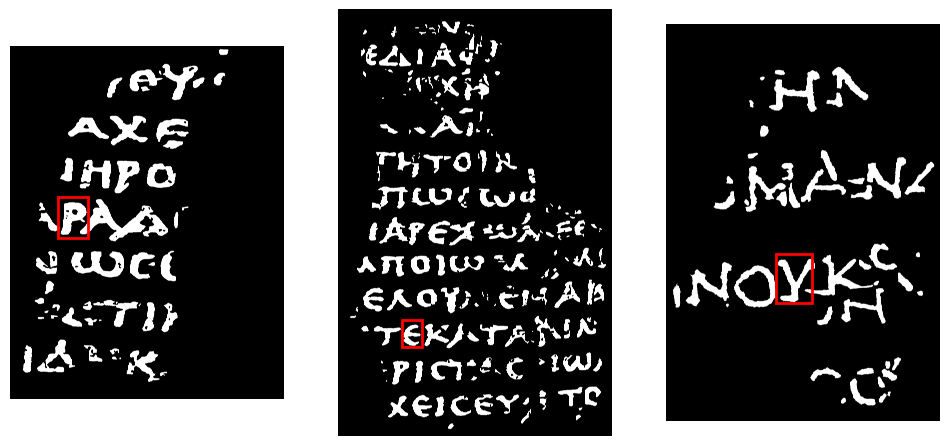

In [29]:

plt.figure(figsize=(12, 6))
show_labels_with_rects([1, 2, 3], BASE_PREFIX, VALIDATION_RECTS)



In [30]:
%%memit
# test get_train_and_val_dsets
import utils
from utils import get_train_and_val_dsets
train_dset, val_dset = get_train_and_val_dsets(
    fragments_to_use=[1,2,3],
    data_path=BASE_PREFIX,
    z_start=Z_START,
    z_dim=Z_DIM,
    buffer=BUFFER,
    validation_rects=VALIDATION_RECTS,
    shuffle=True,
)
print("Num items (pixels) for training set:", len(train_dset))
print("Num items (pixels) for validation set:", len(val_dset))
print(train_dset[0])

Loading fragment 1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment 2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment 3:   0%|          | 0/32 [00:00<?, ?it/s]

Num items (pixels) for training set: 150176631
Num items (pixels) for validation set: 1999953
(tensor([[[[0.3876, 0.3896, 0.3971,  ..., 0.4765, 0.4668, 0.4456],
          [0.3524, 0.3628, 0.3897,  ..., 0.4343, 0.4095, 0.3821],
          [0.3259, 0.3424, 0.3855,  ..., 0.3523, 0.3229, 0.2994],
          ...,
          [0.5899, 0.5950, 0.5912,  ..., 0.1905, 0.1640, 0.1549],
          [0.5722, 0.5788, 0.5704,  ..., 0.1787, 0.1323, 0.0899],
          [0.5280, 0.5368, 0.5300,  ..., 0.1615, 0.1507, 0.1473]],

         [[0.3919, 0.3898, 0.3908,  ..., 0.4489, 0.4346, 0.4193],
          [0.3592, 0.3688, 0.3903,  ..., 0.3800, 0.3509, 0.3280],
          [0.3295, 0.3479, 0.3887,  ..., 0.2852, 0.2529, 0.2342],
          ...,
          [0.5488, 0.5428, 0.5171,  ..., 0.1709, 0.1229, 0.0969],
          [0.5258, 0.5207, 0.4991,  ..., 0.1389, 0.0900, 0.0545],
          [0.4874, 0.4851, 0.4727,  ..., 0.1153, 0.1304, 0.1647]],

         [[0.4012, 0.3922, 0.3851,  ..., 0.3979, 0.3814, 0.3737],
          [0.

In [31]:
gc.collect()

168

In [32]:
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False)
# Since we restart the iteration through the validation loader, it needs to be
# reshuffled.
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=True)
print("Num of training batches:", len(train_loader))
print("Num of validation batches:", len(val_loader))

Num of training batches: 4693020
Num of validation batches: 62499


### Set up model

In [33]:
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [34]:
model = InkDetector().to(DEVICE)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Train

In [9]:
TRAIN_RUN = True # To avoid re-running when saving the notebook

In [10]:
warnings.simplefilter('ignore', UndefinedMetricWarning)

In [17]:
import importlib
importlib.reload(utils)
from utils import Trainer, create_writer

if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD
    
    TRAINING_EPOCHS = 10000
    MODEL_SAVE_PATH = "InkDetector_all_fragments_10k_epochs"
    # log to tensorboard
    writer = utils.create_writer(model_name=MODEL_SAVE_PATH)
    trainer = Trainer(model, train_loader, val_loader, optimizer, criterion, LEARNING_RATE, writer)
    
    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)
    
    # torch.save(model.state_dict(), MODEL_SAVE_PATH)

else:
    model_weights = torch.load(MODEL_SAVE_PATH)
    model.load_state_dict(model_weights)

Created SummaryWriter saving to logs/2023-05-25/InkDetector_all_fragments_10k_epochs.


  0%|          | 0/10000 [00:00<?, ?it/s]

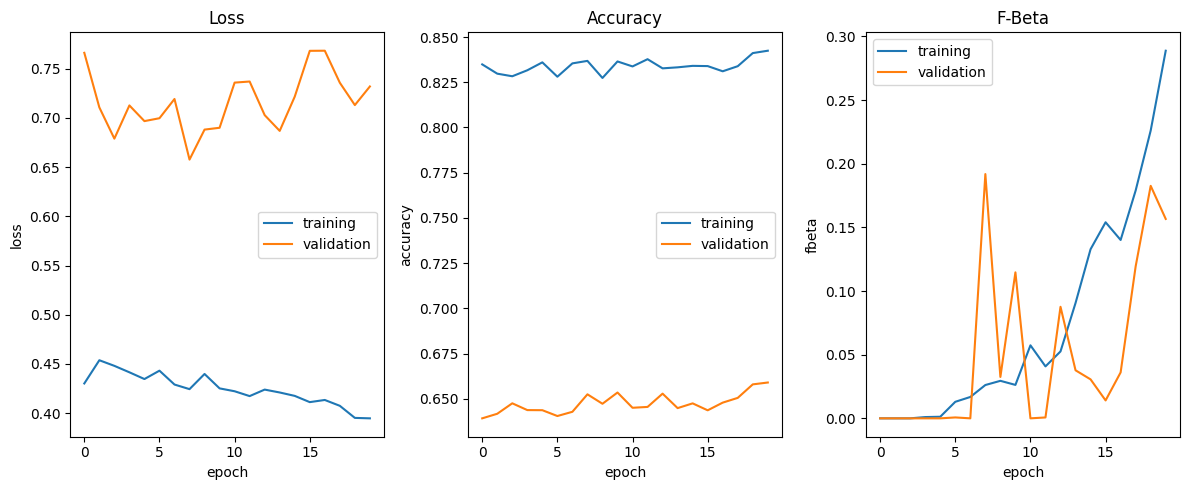

In [18]:
if TRAIN_RUN:
    plt.figure(figsize=(12, 5))
    trainer.plot_metrics()

In [23]:
import importlib
importlib.reload(utils)
from utils import predict_validation_rects

predict_validation_rects(model,
                         fragments_to_use=[1,2,3],
                         data_path=BASE_PREFIX,
                         z_start=Z_START,
                         z_dim=Z_DIM,
                         buffer=BUFFER,
                         validation_rects=VALIDATION_RECTS,
                         writer=writer)


Loading fragment 1:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting on fragment 1:   0%|          | 0/20833 [00:00<?, ?it/s]

Loading fragment 2:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting on fragment 2:   0%|          | 0/20833 [00:00<?, ?it/s]

Loading fragment 3:   0%|          | 0/32 [00:00<?, ?it/s]

Predicting on fragment 3:   0%|          | 0/20833 [00:00<?, ?it/s]

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6004

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Question:** On fragments 1 and 3, the letter shape is at least recognizable, but not on fragment 2. Any idea why that would be?

### Evaluate

In [17]:
print([x for x in dir() if not x.startswith('_')])

['BASE_PREFIX', 'BATCH_SIZE', 'BUFFER', 'DEVICE', 'Dict', 'Image', 'In', 'InkDetector', 'LEARNING_RATE', 'List', 'MODEL_SAVE_PATH', 'Optional', 'Out', 'PREFIX', 'Path', 'SimpleNamespace', 'SubvolumeDataset', 'TEST_PREFIX', 'TRAINING_EPOCHS', 'TRAIN_PREFIX', 'TRAIN_RUN', 'Trainer', 'Tuple', 'UndefinedMetricWarning', 'VALIDATION_EPOCHS', 'VALIDATION_RECTS', 'Z_DIM', 'Z_START', 'arr_mask', 'ax', 'axs', 'data', 'defaultdict', 'exit', 'fbeta_score', 'fig', 'gc', 'get_ipython', 'glob', 'i', 'image_shape', 'image_stack', 'images', 'inside_rect', 'json', 'label', 'mask', 'model', 'model_weights', 'mp', 'nn', 'not_border', 'np', 'open', 'optim', 'os', 'output', 'outputs', 'outside_rect', 'patch', 'patches', 'pd', 'pixels_inside_rect', 'pixels_outside_rect', 'plt', 'pred_image', 'pred_images', 'prob', 'quit', 'rect', 'subfigs', 'subvolumes', 'torch', 'tqdm', 'train_dset', 'train_dsets', 'train_loader', 'val_dset', 'val_dsets', 'warnings', 'x', 'y']


In [20]:
# Clear memory before loading test fragments
to_delete = [
    'image_stack',
    'train_dset',
    'train_dsets',
    'train_loader',
    'val_dset',
    'val_dsets',
    'val_loader'
]
for name in to_delete:
    if name in dir():
        exec('del ' + name)
gc.collect()

0

In [21]:
test_path = Path(TEST_PREFIX)
test_fragments = list(test_path.iterdir())
print("All fragments:", test_fragments)

All fragments: [PosixPath('data/test/a'), PosixPath('data/test/b')]


In [ ]:
# Predict on test fragments
pred_images = []
model.eval()
for test_fragment in test_fragments:
    outputs = []
    test_pixels = get_pixels_using_mask(fragments=[test_fragment])
    eval_dset = SubvolumeDataset(fragments=[test_fragment], voxel_shape=(48, 64, 64), load_inklabels=False,pixels=test_pixels)
    eval_loader = thd.DataLoader(eval_dset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
            output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
            outputs.append(output)
    # we only load 1 fragment at a time
    image_shape = eval_dset.image_stacks[0].shape[1:]
    eval_dset.labels = None
    eval_dset.image_stacks = None
    del eval_loader
    gc.collect()

    pred_image = np.zeros(image_shape, dtype=np.uint8)
    outputs = np.concatenate(outputs)
    for (y, x, _), prob in zip(eval_dset.pixels[:outputs.shape[0]], outputs):
        pred_image[y ,x] = prob > 0.4
    pred_images.append(pred_image)
    
    eval_dset.pixels = None
    del eval_dset
    gc.collect()
    print("Finished", test_fragment)

### Submission

In [ ]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
submission = defaultdict(list)
for fragment_id, fragment_name in enumerate(test_fragments):
    submission["Id"].append(fragment_name.name)
    submission["Predicted"].append(rle(pred_images[fragment_id]))


In [ ]:
pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)
pd.DataFrame.from_dict(submission)